# Lab 4: Inference and Capital Punishment, Part 2

Welcome to Lab 4! This week, we will continue to investigate the relationship between murder rates and capital punishment in the United States. Please complete Lab 3 before starting Lab 4.

By the end of this lab, you should know how to:

1. Test whether observed data appears to be a random sample from a distribution.
2. Analyze a natural experiment.
3. Implement and interpret a sign test.
4. Create a function to run a general hypothesis test.
5. Analyze visualizations and draw conclusions from them.

All of the concepts necessary for this project are found in the [Inferential Thinking textbook](https://www.inferentialthinking.com/). If you are stuck on a particular problem, reading through the relevant textbook section often will help clarify the concept. 

To get started, load `datascience`, `numpy`, `plots`, and `okgrade`.

In [2]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Overview: Recap

In the United States, some jurisdictions execute some people who are convicted of particularly serious crimes, such as murder.  This punishment is called the *death penalty* or *capital punishment*.  The death penalty is controversial, and deterrence has been one focal point of the debate.  There are other reasons to support or oppose the death penalty, but in this project we'll focus on deterrence.

The key question about deterrence is:

> Through our exploration, does instituting a death penalty for murder actually reduce the number of murders?

You might have a strong intuition in one direction, but the evidence turns out to be surprisingly complex.  Different sides have variously argued that the death penalty has no deterrent effect and that each execution prevents 8 murders, all using statistical arguments!  We'll try to come to our own conclusion.

In Lab 3, we completed the following tasks:

1. In section 1, we explored the data.
2. In section 2, we tested a null hypothesis that murder rates were equally likely to go up or down each year, as if by a flip of a fair coin.

**If you do not remember lab 3, we highly recommend you go back and review it now. It will help you for this lab. **

In Lab 4, we will complete the following tasks:

1. In section 3, we'll apply a similar test to see whether U.S. states that suddenly ended or reinstituted the death penalty were more likely to see murder rates increase than decrease.
2. In section 4, we'll run some more tests to support claims that we had been investigating in previous sections. 
3. In section 5, we'll try to answer our question about deterrence using a visualization rather than a formal hypothesis test.

#### The data

The main data source for this project comes from a [paper](http://cjlf.org/deathpenalty/DezRubShepDeterFinal.pdf) by three researchers, Dezhbakhsh, Rubin, and Shepherd.  The dataset contains rates of various violent crimes for every year 1960-2003 (44 years) in every US state.  The researchers compiled the data from the FBI's Uniform Crime Reports.

Since crimes are committed by people, not states, we need to account for the number of people in each state when we're looking at state-level data.  Murder rates are calculated as follows:

$$\text{murder rate for state X in year Y} = \frac{\text{number of murders in state X in year Y}}{\text{population in state X in year Y}}*100000$$

(Murder is rare, so we multiply by 100,000 just to avoid dealing with tiny numbers.)

In [4]:
murder_rates = Table.read_table('crime_rates.csv').select('State', 'Year', 'Population', 'Murder Rate')
murder_rates.set_format("Population", NumberFormatter)

def diff_n(values, n):
    return np.array(values)[n:] - np.array(values)[:-n]

def two_year_changes(rates):
    "Return the number of increases minus the number of decreases after two years."
    return np.count_nonzero(diff_n(rates, 2) > 0) - np.count_nonzero(diff_n(rates, 2) < 0)

As a reminder of our hypothesis test, here are the null hypothesis, alternative hypothesis, and test statistic from lab 3.

> **Null Hypothesis**: State murder rates increase and decrease over two-year periods as if 
"increase" or "decrease" were sampled at random from a uniform distribution, like a fair coin flip.

> **Alternative Hypothesis**: State murder rates are more likely to increase over two-year periods.

> **Test Statistic**: The number of increases minus the number of decreases

## 1. The death penalty

Some US states have the death penalty, and others don't, and laws have changed over time. In addition to changes in murder rates, we will also consider whether the death penalty was in force in each state and each year.

Using this information, we would like to investigate how the presence of the death penalty affects the murder rate of a state.

**Question 1.1.** <br/>Describe this investigation in terms of an experiment. What population are we studying? What is the control group? What is the treatment group? What outcome are we measuring? Be precise!

- Population: All US State-Year combinations
- Control Group: All US State-Year combinations in which the death penalty was not in effect
- Treatment Group: States that institute the death penalty from our population
- Outcome: Murder rates of each US state-year combination

**Question 1.2.** <br/>We want to know whether the death penalty *causes* a change in the murder rate.  Why is it not sufficient to compare murder rates in places and times when the death penalty was in force with places and times when it wasn't?

*Association is not enough to determine causality. It is possible for any two given factors to be positively or negatively associated with each other, but more evidence is required to determine causality.*

**Your answers for Questions 1.1 and 1.2 are not graded. To check your answers, go onto the edX discussion forum for lab 4 and check your answers with other students!**

### A Natural Experiment

In order to attempt to investigate the causal relationship between the death penalty and murder rates, we're going to take advantage of a *natural experiment*.  A natural experiment happens when something other than experimental design applies a treatment to one group and not to another (control) group, and we have some hope that the treatment and control groups don't have any other systematic differences.

Our natural experiment is this: in 1972, a Supreme Court decision called *Furman v. Georgia* banned the death penalty throughout the US.  Suddenly, many states went from having the death penalty to not having the death penalty.

As a first step, let's see how murder rates changed before and after the court decision.  We'll define the test as follows:

> **Population:** All the states that had the death penalty before the 1972 abolition.  (There is no control group for the states that already lacked the death penalty in 1972, so we must omit them.)  This includes all US states **except** Alaska, Hawaii, Maine, Michigan, Wisconsin, and Minnesota.

> **Treatment group:** The states in that population, in the year after 1972.

> **Control group:** The states in that population, in the year before 1972.

> **Null hypothesis:** Each state's murder rate was equally likely to be higher or lower in the treatment period than in the control period.  (Whether the murder rate increased or decreased in each state was like the flip of a fair coin.)

> **Alternative hypothesis:** The murder rate was more likely to increase.

Our alternative hypothesis is in keeping with our suspicion that murder rates increase when the death penalty is eliminated.  

*Technical Note:* It's not clear that the murder rates were a "sample" from any larger population.  Again, it's useful to imagine that our data could have come out differently and to test the null hypothesis that the murder rates were equally likely to move up or down.

The `death_penalty` table below describes whether each state allowed the death penalty in 1971.

In [5]:
non_death_penalty_states = make_array('Alaska', 'Hawaii', 'Maine', 'Michigan', 'Wisconsin', 'Minnesota')
def had_death_penalty_in_1971(state):
    """Returns True if the argument is the name of a state that had the death penalty in 1971."""
    # The implementation of this function uses a bit of syntax
    # we haven't seen before.  Just trust that it behaves as its
    # documentation claims.
    return state not in non_death_penalty_states

states = murder_rates.group('State').select('State')
death_penalty = states.with_column('Death Penalty', states.apply(had_death_penalty_in_1971, 0))
death_penalty

State,Death Penalty
Alabama,True
Alaska,False
Arizona,True
Arkansas,True
California,True
Colorado,True
Connecticut,True
Delaware,True
Florida,True
Georgia,True


In [6]:
num_death_penalty_states = death_penalty.where("Death Penalty", are.equal_to(True)).num_rows
num_death_penalty_states

44

**Question 1.3.** <br/>Assign `death_penalty_murder_rates` to a table with the same columns and data as `murder_rates`, but that has only the rows for states that had the death penalty in 1971.

The first 2 rows of your table should look like this:

|State|Year|Population|Murder Rate|
|-----|----|----------|-----------|
|Alabama|1960|3,266,740|12.4|
|Alabama|1961|3,302,000|12.9|

In [7]:
death_penalty_murder_rates = murder_rates.join("State", death_penalty, "State").where("Death Penalty", True).drop("Death Penalty")
death_penalty_murder_rates

State,Year,Population,Murder Rate
Alabama,1960,"3,266,740",12.4
Alabama,1961,"3,302,000",12.9
Alabama,1962,"3,358,000",9.4
Alabama,1963,"3,347,000",10.2
Alabama,1964,"3,407,000",9.3
Alabama,1965,"3,462,000",11.4
Alabama,1966,"3,517,000",10.9
Alabama,1967,"3,540,000",11.7
Alabama,1968,"3,566,000",11.8
Alabama,1969,"3,531,000",13.7


The null hypothesis doesn't specify *how* the murder rate changes; it only talks about increasing or decreasing.  So, we will use the same test statistic we defined in lab 3.

**Question 1.4.** <br/>Assign `test_stat_72` to the value of the test statistic for the years 1971 to 1973 using the states in `death_penalty_murder_rates`. As before, the test statistic is, "the number of increases minus the number of decreases."

*Hint:* It may be helpful to use multiple lines to work through each part of your solution. One way to proceed is to `group` using your `two_year_changes` function on a table that contains only the range of years you care about.

In [8]:
test_stat_72 = death_penalty_murder_rates.where("Year",are.between(1971,1974)).group("State", collect = two_year_changes).column(3)
test_stat_72 = np.sum(test_stat_72)
print('Test statistic from 1971 to 1973:', test_stat_72)

Test statistic from 1971 to 1973: 22


**Question 1.5.** <br/>Draw an empirical histogram of the statistic under the null hypothesis by simulating the test statistic 10,000 times.

*Hint:* You may find the `simulate_under_null` function from lab 3 useful.

In [9]:
def simulate_under_null(num_chances_to_change):
    """Simulates some number changing several times, with an equal
    chance to increase or decrease.  Returns the value of your
    test statistic for these simulated changes.
    
    num_chances_to_change is the number of times the number changes.
    """
    uniform = Table().with_columns(
        "Change", make_array('Increase', 'Decrease'),
        "Chance", make_array(0.5,        0.5))
    sample = uniform.sample_from_distribution('Chance', num_chances_to_change)
    return sample.column(2).item(0) - sample.column(2).item(1)

In [10]:
samples = make_array()
for i in np.arange(10000):
    samples = np.append(samples, simulate_under_null(num_death_penalty_states))

samples

array([-10.,  -4.,  10., ...,  -4.,  -2.,  -8.])

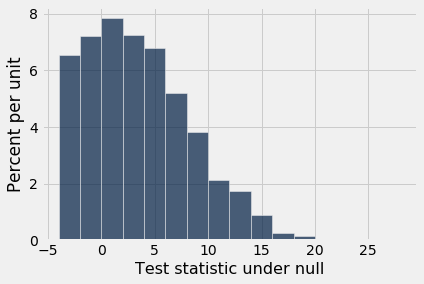

In [11]:
# Run this cell to draw an empirical histogram of the 
# statistic under the null hypothesis.
Table().with_column('Test statistic under null', samples).hist(bins=np.arange(-4, 28+2, 2))

### Conclusion
**Question 1.6.** <br/>Complete the analysis as follows:
1. Compute a P-value.
2. Using a 5% P-value cutoff, draw a conclusion about the null and alternative hypotheses.
3. Describe your findings using simple, non-technical language. What does your analysis tell you about murder rates after the death penalty was suspended? What can you claim about causation from your statistical analysis?

**P-value:** 0.0019

**Conclusion about the hypotheses:** We must reject the null hypothesis because the P-value indicates that only .19% of instances simulated under the null hypothesis are at least as extreme as the actual test statistic.

**Findings:** In other words, it is extremely unlikely that this difference in murder rates is completely coincidental and that the change in the death penalty legislation made no difference to the murder rates across the country.

In [12]:
# P-value
np.mean(np.abs(samples) >= test_stat_72)

0.0008

## 2. Further evidence

So far, we have discovered evidence that when executions were outlawed, the murder rate increased in many more states than we would expect from random chance. We have also seen that across all states and all recent years, the murder rate goes up about as much as it goes down over two-year periods. 

These discoveries seem to support the claim that eliminating the death penalty increases the murder rate. Should we be convinced? Let's conduct some more tests to strengthen our claim.

Conducting a test for this data set requires the following steps:

1. Select a table containing murder rates for certain states and all years,
2. Choose two years and compute the observed value of the test statistic,
3. Simulate the test statistic under the null hypothesis that increases and decreases are drawn uniformly at random, then
4. Compare the observed difference to the empirical distribution to compute a P-value.

This entire process can be expressed in a single function, called `run_test`. It takes the following arguments:

- a table of murder `rates` for certain states, sorted by state and year like `murder_rates`
- the year when the analysis starts (the comparison group is two years later)

It prints out the observed test statistic and returns the P-value for this statistic under the null hypothesis.

`run_test` works regardless of the direction of association in your alternative hypothesis by accounting for whether `observed_test_statistic` is negative or positive.

Run the cell below to define `run_test`. Make sure you understand what it's doing and why.

In [13]:
def run_test(rates, start_year):
    """Prints out the observed test statistic and returns a P-value for this statistic under the null hypothesis
    Parameters
    ----------
    rates : Table
       A table of murder rates for certain states, sorted by state and year like murder_rates
    start_year : int
       The year when the analysis starts
    """
    end_year = start_year + 2
    observed_test_statistic = sum(rates.where('Year', are.between_or_equal_to(start_year, end_year)).select('State', 'Murder Rate').group('State', two_year_changes).column(1))
    print('Test statistic', start_year, 'to', end_year, ':', observed_test_statistic)
    num_states = rates.group('State').num_rows
    
    samples = []
    for i in np.arange(5000):
        samples.append(simulate_under_null(num_states))
    samples = np.array(samples) # Convert from a list to an array
    
    if observed_test_statistic > 0:
        return sum(samples >= observed_test_statistic) / len(samples)
    elif observed_test_statistic < 0:
        return sum(samples <= observed_test_statistic) / len(samples)
    
run_test(death_penalty_murder_rates, 1971)

Test statistic 1971 to 1973 : 22


0.0006

### The rest of the states

We found a dramatic increase in murder rates for those states affected by the 1972 Supreme Court ruling, but what about the rest of the states? There were six states that had already outlawed execution at the time of the ruling.

**Question 2.1.** Create a table called `non_death_penalty_murder_rates` with the same columns as `murder_rates` but only containing rows for the six states without the death penalty in 1971. Perform the same test on this table. **Then**, set `reject_null_2` to whether their murder rates were also more likely to increase from 1971 to 1973.

*Hint:* Feel free to use additional lines for your solution.

In [14]:
non_death_penalty_murder_rates = murder_rates.join("State", death_penalty).where("Death Penalty", False).drop("Death Penalty")
non_death_penalty_murder_rates.show(10)
run_test(non_death_penalty_murder_rates, 1971)

State,Year,Population,Murder Rate
Alaska,1960,"226,167",10.2
Alaska,1961,"234,000",11.5
Alaska,1962,"246,000",4.5
Alaska,1963,"248,000",6.5
Alaska,1964,"250,000",10.4
Alaska,1965,"253,000",6.3
Alaska,1966,"272,000",12.9
Alaska,1967,"272,000",9.6
Alaska,1968,"277,000",10.5
Alaska,1969,"282,000",10.6


Test statistic 1971 to 1973 : 1


0.3566

In [15]:
reject_null_2 = False # I don't really understand what this is asking for but we can definitely say
# that we fail to reject because the p-value is greater than 0.05.

### The death penalty reinstated

In 1976, the Supreme Court repealed its ban on the death penalty in its rulings on [a series of cases including Gregg v. Georgia](https://en.wikipedia.org/wiki/Gregg_v._Georgia), so the death penalty was reinstated where it was previously banned.  This generated a second natural experiment.  To the extent that the death penalty deters murder, reinstating it should decrease murder rates, just as banning it should increase them. Let's see what happened.

In [16]:
print("Increases minus decreases from 1975 to 1977 (when the death penalty was reinstated) among death penalty states:",
      sum(death_penalty_murder_rates.where('Year', are.between_or_equal_to(1975, 1977))
                                    .group('State', two_year_changes)
                                    .column("Murder Rate two_year_changes")))
run_test(death_penalty_murder_rates, 1975)

Increases minus decreases from 1975 to 1977 (when the death penalty was reinstated) among death penalty states: -18
Test statistic 1975 to 1977 : -18


0.0034

**Question 2.2.** Now we've analyzed states where the death penalty went away and came back, as well as states where the death penalty was outlawed all along.  What do you conclude from  the results of the tests we have conducted so far? Does all the evidence consistently point toward one conclusion, or is there a contradiction?

1) Our results point toward the conclusion that the death penalty moratorium increased murder rates.

2) Our results point toward the conclusion that the death penalty moratorium increased murder rates, but we have not accounted for differences over time as a confounding factor.

3) Our results don't allow us to make any conclusion about murder rates and death penalties.

4) Our results point toward the conclusion that the death penalty moratorium didn't influence murder rates.

5) None of these conclusions are valid, or multiple of these conclusions are valid

Below, set we_conclude to a single number, corresponding to your answer.

In [17]:
we_conclude = 2

## 3. Visualization

While our analysis appears to support the conclusion that the death penalty deters murder, [a 2006 Stanford Law Review paper](http://users.nber.org/~jwolfers/papers/DeathPenalty%28SLR%29.pdf) argues the opposite: that historical murder rates do **not** provide evidence that the death penalty deters murderers.

To understand their argument, we will draw a picture.  In fact, we've gone at this whole analysis rather backward; typically we should draw a picture first and ask precise statistical questions later!

What plot should we draw?

We know that we want to compare murder rates of states with and without the death penalty.  We know we should focus on the period around the two natural experiments of 1972 and 1976, and we want to understand the evolution of murder rates over time for those groups of states.  It might be useful to look at other time periods, so let's plot them all for good measure.

**Question 3.1.** <br/>Create a table called `average_murder_rates` with 1 row for each year in `murder_rates`.  It should have 3 columns:
* `Year`, the year,
* `Death penalty states`, the average murder rate of the states that had the death penalty in 1971, and
* `No death penalty states`, the average murder rate of the other states.

`average_murder_rates` should be sorted in increasing order by year.  Its first three rows should look like:

|Year|Death penalty states|No death penalty states|
|-|-|-|
|1960| | |
|1961| | |
|1962| | ||

*Hint 1:*  It's easiest to use `pivot`. We don't expect you to account for differences in population.

*Hint 2:* You can reorder columns in a table using `.select`.

In [23]:
# For reference, our solution used 5 method calls
average_murder_rates = murder_rates.join("State", death_penalty).pivot("Death Penalty", "Year", values= "Murder Rate", collect=np.mean).relabel("True", "Death penalty states").relabel("False", "No death penalty states")
average_murder_rates

Year,No death penalty states,Death penalty states
1960,3.55,5.27955
1961,3.68333,4.77727
1962,2.33333,4.61591
1963,2.75,4.61364
1964,3.4,4.71136
1965,3.18333,4.82727
1966,4.51667,5.43182
1967,3.73333,5.875
1968,4.73333,6.27045
1969,4.73333,6.50227


Let's take a look at the line plot below. Are the murder rates in these two groups of states related?

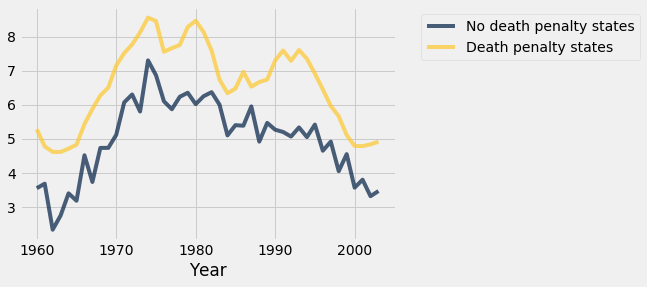

In [24]:
average_murder_rates.plot('Year')

Yes, murder rates in the two groups of states are related as we can see that they share a similar trend in the plot above.

Let's bring in another source of information: Canada.

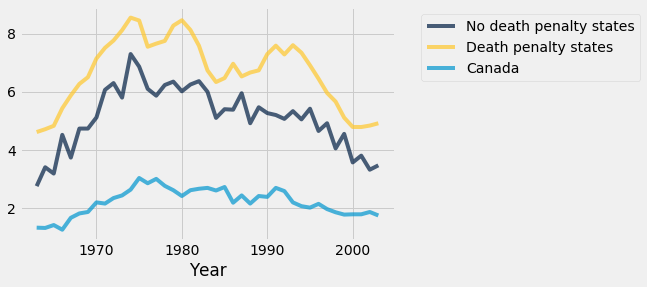

In [26]:
canada = Table.read_table('canada.csv')
murder_rates_with_canada = average_murder_rates.join("Year", canada.select("Year", "Homicide").relabeled("Homicide", "Canada"))
murder_rates_with_canada.plot('Year')

The line plot we generated above is similar to a figure from the [paper](http://users.nber.org/~jwolfers/papers/DeathPenalty%28SLR%29.pdf).

<img src="paper_plot.png" alt="Homicide Rates in the United States vs Canada."/>

Canada has not executed a criminal since 1962. Since 1967, the only crime that can be punished by execution in Canada is the murder of on-duty law enforcement personnel. The paper states, "The most striking finding is that the homicide rate in Canada has moved in
virtual lockstep with the rate in the United States."

From the plots, we can conclude that murder rates in the two countries moved together even around points where death penalty legislation was passed. This seems to suggest that other changes over time determined murder rates in both countries, rather than one or the other's legislation. This and the plots indicate that the death penalty is not an important factor in determining the murder rateFor more information, read the [paper](http://users.nber.org/~jwolfers/papers/DeathPenalty%28SLR%29.pdf).

**Conclusion**. The authors that created this visualization argue that even though murder rates increased when the death penalty was taken away, and decreased when it was reintroduced, these changes were probably not caused by the death penalty itself.